In [1]:
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import HexGrid
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [9]:
class Community():
    def __init__(self):
        self.population = np.random.randint(5, 1000)
        self.food = np.random.randint(0, 25e3)
        self.goods = np.random.randint(0, 1e3)
        self.buildings = np.random.randint(0, 10)
        self.trade = np.random.randint(0, 10)
        self.defense = np.random.randint(0, 10)
        
class Village(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model, properties):
        super().__init__(unique_id, model)
        #self.wealth = 1
        for k, v in properties.items():
            self.__setattr__(k, v)
        print(properties)

    def step(self):
        if self.population == 0:
            return
        if self.food/self.population < 25:
            #print(self.food/self.population)
            try:
                other_agent = self.random.choice(self.model.schedule.agents)
                leave_N = np.random.randint(0, self.population-self.food/25+1)
                other_agent.population += leave_N
                self.population -= leave_N
            except ValueError:
                print(self.food, self.population, self.food/self.population, 
                      self.food%25+1, self.food%25, self.population-self.food/25)

        
        
class Kingdom(Model):
    """A model with some number of agents."""
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.grid = HexGrid(N, N, False)
        # Create agents
        for i in range(self.num_agents):
            a = Village(i, self, Community().__dict__)
            self.schedule.add(a)
            self.grid.place_agent(a, self.grid.find_empty())
            
    
    def update_totals(self):
        self.totalfood = 0
        self.totalpop = 0
        for a in self.schedule.agents:
            self.totalfood += a.food
            self.totalpop += a.population
        
    
    def fix_food(self):
        self.update_totals()
        print('total food in kingdom: ', self.totalfood/25, self.totalpop)
        print('Sufficient food in kingdom: ', self.totalfood/25 >= self.totalpop)
        if self.totalfood/25 >= self.totalpop:
            return
        while self.totalfood/25 < self.totalpop:
            a = self.random.choice(self.schedule.agents)
            a.food += np.random.randint(1, (self.totalpop+1)*25-self.totalfood)
            self.update_totals()
        print('After update...')
        print('total food in kingdom: ', self.totalfood/25, self.totalpop)
        print('Sufficient food in kingdom: ', self.totalfood/25 >= self.totalpop)
        
        

    def step(self):
        '''Advance the model by one step.'''
        self.schedule.step()

In [27]:
model.grid.get_neighbors((5,5), radius=2)
model.grid.

[<__main__.Village at 0x1ec1567f2b0>, <__main__.Village at 0x1ec1567f550>]

{'population': 415, 'food': 16697, 'goods': 691, 'buildings': 8, 'trade': 3, 'defense': 9}
{'population': 122, 'food': 9302, 'goods': 768, 'buildings': 0, 'trade': 3, 'defense': 4}
{'population': 597, 'food': 2762, 'goods': 218, 'buildings': 0, 'trade': 4, 'defense': 4}
{'population': 658, 'food': 24448, 'goods': 466, 'buildings': 8, 'trade': 8, 'defense': 3}
{'population': 119, 'food': 16587, 'goods': 749, 'buildings': 0, 'trade': 3, 'defense': 5}
{'population': 635, 'food': 21219, 'goods': 326, 'buildings': 9, 'trade': 3, 'defense': 9}
{'population': 98, 'food': 1307, 'goods': 801, 'buildings': 2, 'trade': 0, 'defense': 1}
{'population': 880, 'food': 15262, 'goods': 886, 'buildings': 6, 'trade': 2, 'defense': 1}
{'population': 947, 'food': 24551, 'goods': 249, 'buildings': 9, 'trade': 8, 'defense': 5}
{'population': 467, 'food': 5805, 'goods': 630, 'buildings': 8, 'trade': 3, 'defense': 3}
total food in kingdom:  5517.6 4938
Sufficient food in kingdom:  True
100


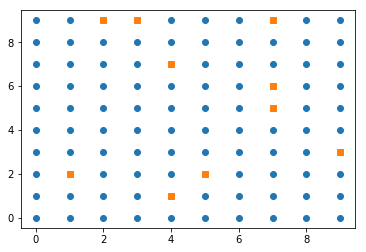

In [16]:
N = 10
model = Kingdom(N)
model.fix_food()

count = 0
x = []
y = []
for c in model.grid.coord_iter():
    x.append(c[1])
    y.append(c[2])
    count += 1
print(count)
plt.plot(x, y, 'o')

xv = [a.pos[0] for a in model.schedule.agents]
yv = [a.pos[1] for a in model.schedule.agents]
plt.plot(xv, yv, 's')

{'population': 429, 'food': 16993, 'goods': 103, 'buildings': 1, 'trade': 6, 'defense': 1}
{'population': 66, 'food': 13168, 'goods': 425, 'buildings': 7, 'trade': 7, 'defense': 0}
{'population': 877, 'food': 7427, 'goods': 805, 'buildings': 6, 'trade': 8, 'defense': 2}
{'population': 670, 'food': 19398, 'goods': 992, 'buildings': 7, 'trade': 0, 'defense': 1}
{'population': 933, 'food': 13748, 'goods': 2, 'buildings': 1, 'trade': 7, 'defense': 8}
{'population': 519, 'food': 13349, 'goods': 726, 'buildings': 8, 'trade': 5, 'defense': 5}
{'population': 229, 'food': 13521, 'goods': 670, 'buildings': 4, 'trade': 8, 'defense': 7}
{'population': 229, 'food': 7144, 'goods': 660, 'buildings': 4, 'trade': 3, 'defense': 7}
{'population': 650, 'food': 24754, 'goods': 262, 'buildings': 5, 'trade': 3, 'defense': 8}
{'population': 52, 'food': 312, 'goods': 333, 'buildings': 4, 'trade': 9, 'defense': 7}
total food in kingdom:  5192.56 4654
Sufficient food in kingdom:  True


<BarContainer object of 10 artists>

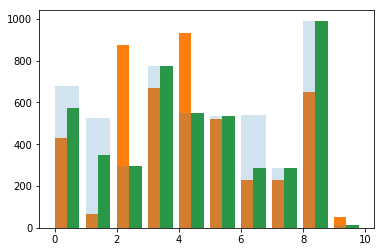

In [28]:
N = 10
model = Kingdom(N)
model.fix_food()

food = [a.food/25 for a in model.schedule.agents]
plt.bar(np.arange(model.num_agents), food, 0.8, zorder=10, align='edge', alpha=0.2)

population = [a.population for a in model.schedule.agents]
plt.bar(np.arange(model.num_agents), population, 0.4, align='edge')

for i in range(100):
    model.step()
    
population = [a.population for a in model.schedule.agents]
#plt.hist(population)
plt.bar(np.arange(model.num_agents)+0.4, population, 0.4, align='edge')

In [19]:
a = model.schedule.agents[0]
community = Community()
#v = Village(0, Kingdom)
print(community.__dict__)
print(community.__getattribute__('population'))
community.__setattr__('population', 10)
community.__getattribute__('population')


{'population': 589, 'food': 23934, 'goods': 297, 'buildings': 4, 'trade': 3, 'defense': 0}
589


10

<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Comm

<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Community'>, NULL>
<super: <class 'Comm

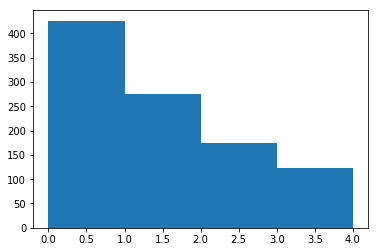

In [50]:
all_wealth = []
for j in range(100):
    # Run the model
    model = Kingdom(10)
    for i in range(10):
        model.step()
    
    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

plt.hist(all_wealth, bins=range(max(all_wealth)+1));